In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

#assert torch.cuda.is_available()

# Problem 1
Download the CIFAR10 training and test datasets.
Transform them into tensors, normalize them as described above in the code, and create DataLoaders for each one. 
For the training set, use a batch size of 32, and for the test set, use a batch size of 1.

In [2]:
classes = ('airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks')
transform = transforms.Compose(
                    [transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10('../data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data,batch_size=32,shuffle=False)

test_data = datasets.CIFAR10('../data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data,batch_size=1,shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataiter = iter(train_loader)
images, labels = dataiter.next()
images, labels = images.cuda(), labels.cuda()

Files already downloaded and verified
Files already downloaded and verified


In [3]:
for batch, (x, y_truth) in enumerate(test_loader):
  x, y_truth = x.to(device), y_truth.to(device)

# Problem 2

Create a convolution model class convoles an image of size $3\times 32 \times 32$ into a 1D tensor that represents the $10$ classes.
The model should have at least three convolution layers, each followed by an activation function, and include at least two linear layers and one maxpool layer.
Select channels and kernel sizes so that you get at least $50,000$ parameters.

Calculate and print the number of learnable parameters in your model.

Initialize your model and move it to the device.
Run the model on a single image to make sure there are no errors.


In [4]:
class ConvolutionModel(nn.Module):
  def __init__(self):
    super(ConvolutionModel, self).__init__()

    # Number of parameters: (3*5*5 + 1) * 6 = 456
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
    # Number of parameters: (6*3*3 + 1) * 10 = 550
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=10, kernel_size=3)
    # Number of parameters: (10*3*3 + 1) * 24 = 2,184
    self.conv3 = nn.Conv2d(in_channels=10, out_channels=24, kernel_size=3)
    # Number of parameters: (24*3*3 + 1) * 64 = 13,888
    self.conv4 = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3)
    # Number of parameters: (64*8*8 + 1) * 10 = 40,970
    self.linear = nn.Linear(in_features=64*8*8, out_features=10)

    self.flatten = nn.Flatten()
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2)
    # Total number of parameters: ~58,000

    

  # Call the layers on an image
  def forward(self, x):
    output = self.relu(self.conv1(x))
    output = self.maxpool(output)
    output = self.relu(self.conv2(output))
    output = self.relu(self.conv3(output))
    output = self.relu(self.conv4(output))
    output = self.flatten(output)
    return self.linear(output)



In [5]:
model = ConvolutionModel()
model = model.to(device)
model(images[0].unsqueeze(0))

tensor([[-0.0138, -0.0091, -0.0494,  0.0014, -0.0458, -0.0256, -0.0112, -0.0134,
          0.0092,  0.0158]], device='cuda:0', grad_fn=<AddmmBackward0>)


# Problem 3

Train the model by looping through the training data. Inside the loop, you should
1. Zero out the gradients.
2. Run the model on the inputs.
3. Calculate the loss on the model output and the actual label.
4. Backpropogate the error.
5. Optimize.

Run the loop for 10 epochs. At the end of each epoch, calculate the mean loss of the
training data for that epoch. Then calculate the accuracy of the model on the test data. Since
the model is no longer training, it needs to be set to evaluation mode using model.eval().
To resume training at the beginning of the next epoch, set the model to training mode using
model.train().

You should have around $50\%$ accuracy at the end of $10$ epochs.

Plot the epochs v. mean training loss each epoch and the epochs v. accuracy.


In [6]:
model = ConvolutionModel()
model = model.to(device)

objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss:1.7701: : 15630it [04:52, 77.74it/s]

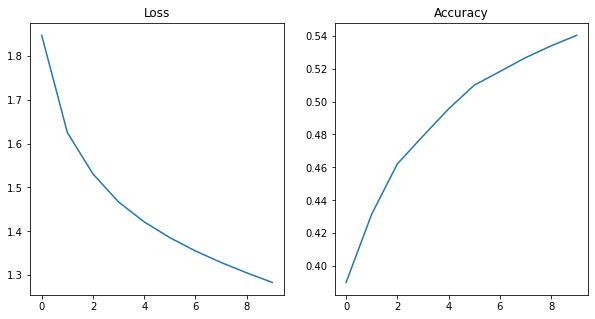

In [7]:
loop = tqdm(total=len(train_loader), position=0)
loop.update()

n_epochs = 10
total_losses = []
accuracies = []

for i in range(n_epochs):
  total_loss = 0
  for batch, (x, y_truth) in enumerate(train_loader):
    x, y_truth = x.to(device), y_truth.to(device)
    optimizer.zero_grad() # Zero out the the gradients
    y_hat = model(x) # Run the model
    loss = objective(y_hat, y_truth) # Calculate loss
    loss.backward() # Compute gradients
    optimizer.step()
    loop.set_description('loss:{:.4f}'.format(loss.item()))
    total_loss += loss.item()
    loop.update()

  # At the end of each epoch,
  # Calculate the man loss of the training data for that epoch
  total_losses.append(total_loss / len(train_loader))
  # Then calculate the accuracy of the model on the test data
  model.eval()
  accuracy = 0
  for batch, (x, y_truth) in enumerate(test_loader):
     x, y_truth = x.to(device), y_truth.to(device)
     y_hat = model(x)
     if torch.argmax(y_hat) == y_truth:
       accuracy += 1
  accuracies.append(accuracy / len(test_loader))
  model.train()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(total_losses)
axs[0].set_title("Loss")
axs[1].plot(accuracies)
axs[1].set_title("Accuracy")
plt.show()

# Problem 4

Write a function that loops through the test data, modifying the images as described.

Run your function for each epsilon in $[0,.05,.1,.15,.2,.25,.3]$, and plot epsilon v. accuracy.

Display the perturbed version of the first image in the test data for each epsilon.

In [8]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Return the perturbed image adding clipping to maintain [-1,1] range
    return torch.clamp(perturbed_image, -1, 1)

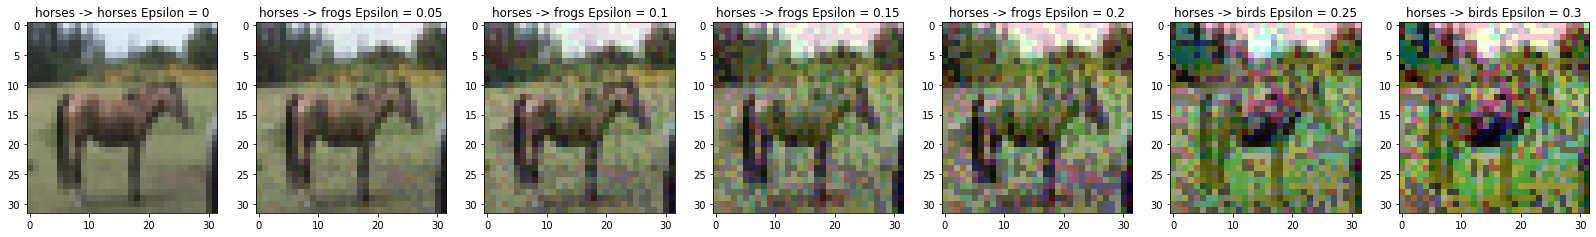

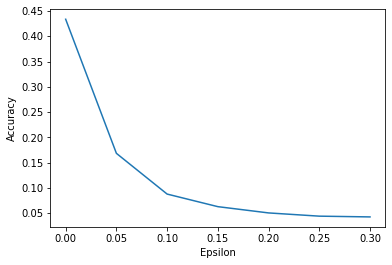

In [13]:
accuracies = []
fig, axs = plt.subplots(1, 7, figsize=(28, 4))
for i, eps in enumerate([0, .05, .1, .15, .2, .25, .3]):
  accuracy = 0
  for batch, (x, y_truth) in enumerate(test_loader):
    x, y_truth = x.to(device), y_truth.to(device)
    x.requires_grad = True
    y_hat = model(x)
    if torch.argmax(y_hat) != y_truth:
      continue
    # Update loss
    loss = objective(y_hat, y_truth) 
    # Zero out gradients
    optimizer.zero_grad()
    # Backwards step
    loss.backward() # Compute gradients
    optimizer.step()
    # data_grad <- x.grad.data
    data_grad = x.grad.data
    # perturbed_data <- fgsm_attack(data, eps, data_grad)
    perturbed_data = fgsm_attack(x, eps, data_grad)
    # output <- model(perturbed_data)
    output = model(perturbed_data)
    if torch.argmax(output) == y_truth:
      accuracy += 1
  accuracies.append(accuracy / len(test_loader))

  ex = perturbed_data.squeeze().detach().cpu().numpy()
  # Plot the image
  img = ex / 2 + 0.5 # unnormalize
  axs[i].imshow(np.transpose(img, (1, 2, 0)))
  axs[i].set_title(classes[y_truth[0]] + " -> " + classes[torch.argmax(output[0])] + " Epsilon = " + str(eps))
plt.show()

plt.plot([0, .05, .1, .15, .2, .25, .3], accuracies)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()